In [15]:
# 모델의 구성 정보를 YAML 파일로 저장합니다.
project_dir = "/data/ephemeral/home/nlp-5/auto1p/" # 본인 경로에 맞게 설정
import os
import sys
sys.path.append(
    project_dir
)
from src.utils.utils import *

import pandas as pd
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

train_df = pd.read_csv(os.path.join(project_dir, 'data','train.csv'))
val_df = pd.read_csv(os.path.join(project_dir, 'data','dev.csv'))
test_df = pd.read_csv(os.path.join(project_dir, 'data','test.csv'))
# sub_df = pd.read_csv(os.path.join(project_dir, 'data','submission_best.csv'))
sub_df = pd.read_csv(os.path.join(project_dir, 'outputs', 'exp_bart_08021819','submission_08021819.csv'))

# train_solar_en2ko = pd.read_csv(os.path.join(project_dir, 'data','train_solar_backtranslate_en2ko.csv'))

In [16]:
test_df['summary'] = sub_df['summary']

- load lenizer

In [17]:
from transformers import AutoTokenizer, BartForConditionalGeneration, BartConfig, AutoModelForSeq2SeqLM, AutoConfig
# model_name = "csebuetnlp/mT5_multilingual_XLSum"
model_name = "upstage/solar-pro2-tokenizer"

# bart_config = BartConfig().from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = BartForConditionalGeneration.from_pretrained(model_name, config=bart_config)
# config = AutoConfig.from_pretrained(model_name)
# model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

- tokenized된 대화문, 요약문의 길이 분포 분석

In [18]:
train_df.columns

Index(['fname', 'dialogue', 'summary', 'topic'], dtype='object')

## 문자열 길이로 분석

In [19]:
from tqdm import tqdm
tqdm.pandas()
# Apply tokenization and count tokens to 'dialogue' and 'summary' columns
print("Processing train_df...")
train_df['dialogue_len_count'] = train_df['dialogue'].progress_apply(len)
train_df['summary_len_count'] = train_df['summary'].progress_apply(len)

print("\nProcessing val_df...")
val_df['dialogue_len_count'] = val_df['dialogue'].progress_apply(len)
val_df['summary_len_count'] = val_df['summary'].progress_apply(len)

print("\nProcessing test_df...")
test_df['dialogue_len_count'] = test_df['dialogue'].progress_apply(len)
test_df['summary_len_count'] = test_df['summary'].progress_apply(len)

# print("\nProcessing train_solars...")
# train_solar_en2ko['dialogue_len_count'] = train_solar_en2ko['dialogue'].progress_apply(len)
# train_solar_en2ko['summary_len_count'] = train_solar_en2ko['summary'].progress_apply(len)


Processing train_df...


100%|██████████| 12457/12457 [00:00<00:00, 1754775.65it/s]



Processing val_df...


100%|██████████| 499/499 [00:00<00:00, 707080.30it/s]



Processing test_df...


100%|██████████| 499/499 [00:00<00:00, 688246.53it/s]


In [20]:
train_df['len_compress_ratio'] = train_df['summary_len_count'] / train_df['dialogue_len_count']
val_df['len_compress_ratio'] = val_df['summary_len_count'] / val_df['dialogue_len_count']
test_df['len_compress_ratio'] = test_df['summary_len_count'] / test_df['dialogue_len_count']
# train_solar_en2ko['len_compress_ratio'] = train_solar_en2ko['summary_len_count'] / train_solar_en2ko['dialogue_len_count']

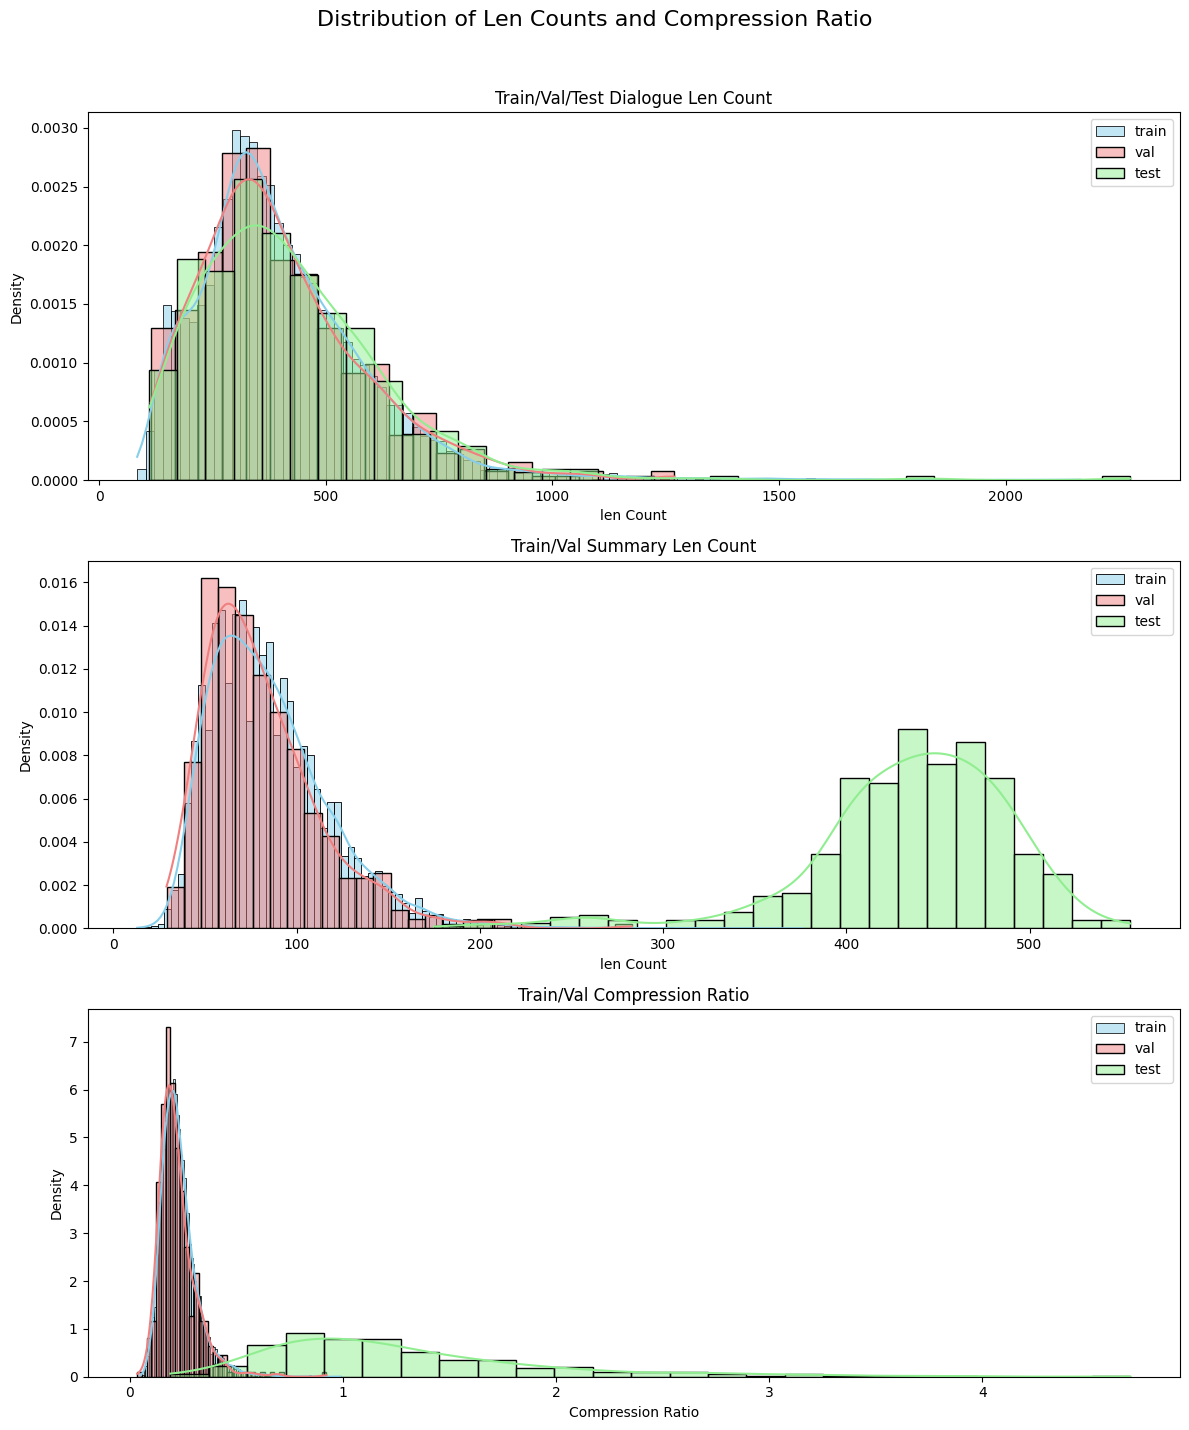

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
# Set up the figure and axes for subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))
fig.suptitle('Distribution of Len Counts and Compression Ratio', fontsize=16)

# Plot for dialogue_len_count
sns.histplot(train_df['dialogue_len_count'], kde=True, ax=axes[0], color='skyblue', stat='density', label='train')
sns.histplot(val_df['dialogue_len_count'], kde=True, ax=axes[0], color='lightcoral', stat='density', label='val')
sns.histplot(test_df['dialogue_len_count'], kde=True, ax=axes[0], color='lightgreen', stat='density', label='test')
# sns.histplot(train_solar_en2ko['dialogue_len_count'], kde=True, ax=axes[0], color='lightgray', stat='density', label='train_solar')
axes[0].set_title('Train/Val/Test Dialogue Len Count')
axes[0].set_xlabel('len Count')
axes[0].set_ylabel('Density')
axes[0].legend()

sns.histplot(train_df['summary_len_count'], kde=True, ax=axes[1], color='skyblue', stat='density', label='train')
sns.histplot(val_df['summary_len_count'], kde=True, ax=axes[1], color='lightcoral', stat='density', label='val')
sns.histplot(test_df['summary_len_count'], kde=True, ax=axes[1], color='lightgreen', stat='density', label='test')
# sns.histplot(train_solar_en2ko['summary_len_count'], kde=True, ax=axes[1], color='lightgray', stat='density', label='train_solar')
axes[1].set_title('Train/Val Summary Len Count')
axes[1].set_xlabel('len Count')
axes[1].set_ylabel('Density')
axes[1].legend()

sns.histplot(train_df['len_compress_ratio'], kde=True, ax=axes[2], color='skyblue', stat='density', label='train')
sns.histplot(val_df['len_compress_ratio'], kde=True, ax=axes[2], color='lightcoral', stat='density', label='val')
sns.histplot(test_df['len_compress_ratio'], kde=True, ax=axes[2], color='lightgreen', stat='density', label='test')
# sns.histplot(train_solar_en2ko['len_compress_ratio'], kde=True, ax=axes[2], color='lightgray', stat='density', label='train_solar')
axes[2].set_title('Train/Val Compression Ratio')
axes[2].set_xlabel('Compression Ratio')
axes[2].set_ylabel('Density')
axes[2].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout to prevent title overlap
plt.show()

In [22]:
# sns.histplot(train_solar_en2ko['len_compress_ratio'], kde=True, color='lightgray', stat='density', label='test')
# plt.show()

## 토큰화 후 길이 분석

In [23]:
from tqdm import tqdm
tqdm.pandas()
def count_tokens(text, tokenizer):
    return len(tokenizer.encode(text, add_special_tokens=True))
# Apply tokenization and count tokens to 'dialogue' and 'summary' columns
print("Processing train_df...")
train_df['dialogue_token_count'] = train_df['dialogue'].progress_apply(lambda x: count_tokens(x, tokenizer))
train_df['summary_token_count'] = train_df['summary'].progress_apply(lambda x: count_tokens(x, tokenizer))

print("\nProcessing val_df...")
val_df['dialogue_token_count'] = val_df['dialogue'].progress_apply(lambda x: count_tokens(x, tokenizer))
val_df['summary_token_count'] = val_df['summary'].progress_apply(lambda x: count_tokens(x, tokenizer))

print("\nProcessing test_df...")
test_df['dialogue_token_count'] = test_df['dialogue'].progress_apply(lambda x: count_tokens(x, tokenizer))
test_df['summary_token_count'] = test_df['summary'].progress_apply(lambda x: count_tokens(x, tokenizer))

# print("\nProcessing train_solar...")
# train_solar_en2ko['dialogue_token_count'] = train_solar_en2ko['dialogue'].progress_apply(lambda x: count_tokens(x, tokenizer))
# train_solar_en2ko['summary_token_count'] = train_solar_en2ko['summary'].progress_apply(lambda x: count_tokens(x, tokenizer))


Processing train_df...


  0%|          | 0/12457 [00:00<?, ?it/s]

100%|██████████| 12457/12457 [00:01<00:00, 11688.01it/s]



Processing val_df...


100%|██████████| 499/499 [00:00<00:00, 12328.70it/s]



Processing test_df...


100%|██████████| 499/499 [00:00<00:00, 3244.74it/s]


In [24]:
train_df['compress_ratio'] = train_df['summary_token_count'] / train_df['dialogue_token_count']
val_df['compress_ratio'] = val_df['summary_token_count'] / val_df['dialogue_token_count']
test_df['compress_ratio'] = test_df['summary_token_count'] / test_df['dialogue_token_count']
# train_solar_en2ko['compress_ratio'] = train_solar_en2ko['summary_token_count'] / train_solar_en2ko['dialogue_token_count']

#### 토큰 길이 분포 - 히스토그램

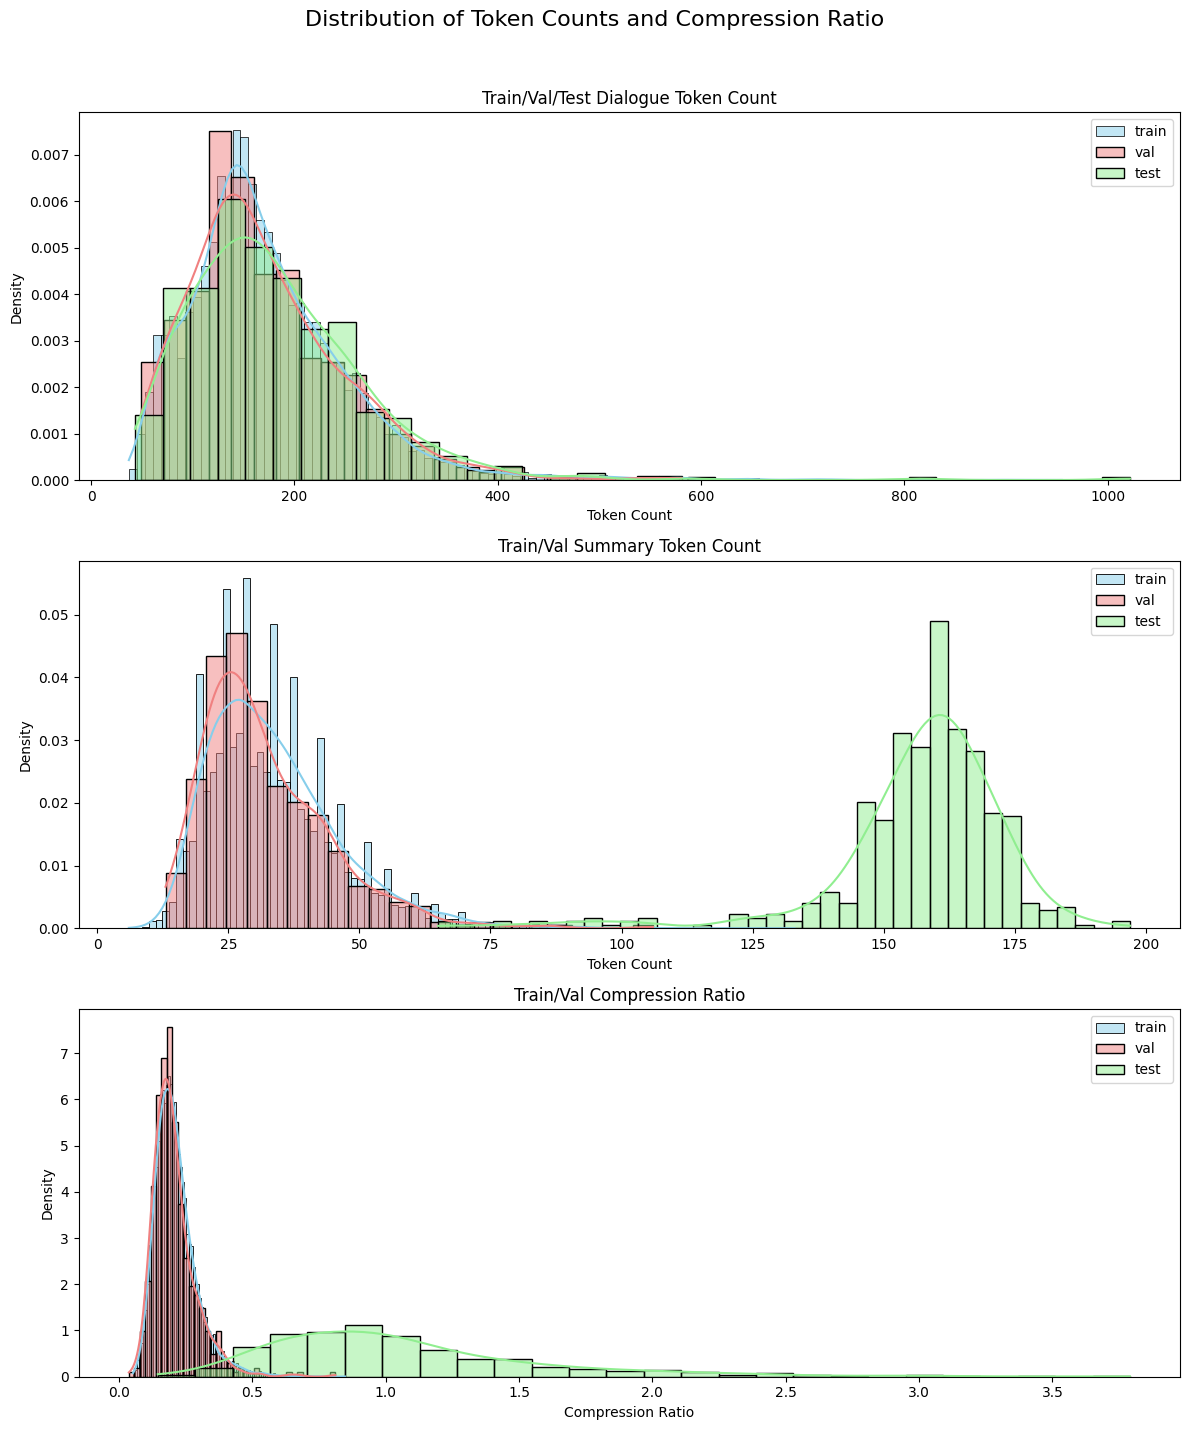

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
# Set up the figure and axes for subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))
fig.suptitle('Distribution of Token Counts and Compression Ratio', fontsize=16)

# Plot for dialogue_token_count
sns.histplot(train_df['dialogue_token_count'], kde=True, ax=axes[0], color='skyblue', stat='density', label='train')
sns.histplot(val_df['dialogue_token_count'], kde=True, ax=axes[0], color='lightcoral', stat='density', label='val')
sns.histplot(test_df['dialogue_token_count'], kde=True, ax=axes[0], color='lightgreen', stat='density', label='test')
# sns.histplot(train_solar_en2ko['dialogue_token_count'], kde=True, ax=axes[0], color='lightgray', stat='density', label='train_solar')
axes[0].set_title('Train/Val/Test Dialogue Token Count')
axes[0].set_xlabel('Token Count')
axes[0].set_ylabel('Density')
axes[0].legend()

sns.histplot(train_df['summary_token_count'], kde=True, ax=axes[1], color='skyblue', stat='density', label='train')
sns.histplot(val_df['summary_token_count'], kde=True, ax=axes[1], color='lightcoral', stat='density', label='val')
sns.histplot(test_df['summary_token_count'], kde=True, ax=axes[1], color='lightgreen', stat='density', label='test')
# sns.histplot(train_solar_en2ko['summary_token_count'], kde=True, ax=axes[1], color='lightgray', stat='density', label='train_solar')
axes[1].set_title('Train/Val Summary Token Count')
axes[1].set_xlabel('Token Count')
axes[1].set_ylabel('Density')
axes[1].legend()

sns.histplot(train_df['compress_ratio'], kde=True, ax=axes[2], color='skyblue', stat='density', label='train')
sns.histplot(val_df['compress_ratio'], kde=True, ax=axes[2], color='lightcoral', stat='density', label='val')
sns.histplot(test_df['compress_ratio'], kde=True, ax=axes[2], color='lightgreen', stat='density', label='test')
# sns.histplot(train_solar_en2ko['compress_ratio'], kde=True, ax=axes[2], color='lightgray', stat='density', label='train_solar')
axes[2].set_title('Train/Val Compression Ratio')
axes[2].set_xlabel('Compression Ratio')
axes[2].set_ylabel('Density')
axes[2].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout to prevent title overlap
plt.show()

In [26]:
# fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))
# fig.suptitle('Distribution of Token Counts and Compression Ratio', fontsize=16)
# sns.histplot(train_solar_en2ko['summary_token_count'], kde=True, ax=axes[0], color='green', stat='density')
# axes[0].set_title('Test Summary Token Count')
# axes[0].set_xlabel('Token Count')
# axes[0].set_ylabel('Density')

# sns.histplot(train_solar_en2ko['compress_ratio'], kde=True, ax=axes[1], color='green', stat='density')
# axes[1].set_title('Train/Val Compression Ratio')
# axes[1].set_xlabel('Compression Ratio')
# axes[1].set_ylabel('Density')

# plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout to prevent title overlap
# plt.show()

#### 토큰 길이 분석 - 상관관계 분석

In [27]:
from scipy.stats import pearsonr

def analyze_and_plot(df, title, ax, color):
    # Calculate outliers based on compression ratio
    lower_bound = df['compress_ratio'].quantile(0.01)
    upper_bound = df['compress_ratio'].quantile(0.99)

    # Identify outlier points
    outliers = df[(df['compress_ratio'] <= lower_bound) | (df['compress_ratio'] >= upper_bound)]
    non_outliers = df[(df['compress_ratio'] > lower_bound) & (df['compress_ratio'] < upper_bound)]

    # Plot non-outliers first
    sns.regplot(x='dialogue_token_count', y='summary_token_count', data=non_outliers,
                ax=ax, scatter_kws={'alpha':0.6, 's':20}, line_kws={'color':color}, ) #label='Normal Points')

    # Plot outliers in red
    if not outliers.empty:
        sns.scatterplot(x='dialogue_token_count', y='summary_token_count', data=outliers,
                        ax=ax, color='red', s=40, ) #label='Outliers (Comp. Ratio <1% or >99%)')

    ax.set_title(title)
    ax.set_xlabel('Dialogue Token Count')
    ax.set_ylabel('Summary Token Count')
    # ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

    # Calculate Pearson correlation coefficient and p-value
    corr, p_value = pearsonr(df['dialogue_token_count'], df['summary_token_count'])
    print(f"\n--- {title} ---")
    print(f"Pearson Correlation Coefficient: {corr:.4f}")
    print(f"P-value: {p_value:.4f}")


--- Train Dataset ---
Pearson Correlation Coefficient: 0.6729
P-value: 0.0000

--- Validation Dataset ---
Pearson Correlation Coefficient: 0.6624
P-value: 0.0000

--- Test Dataset ---
Pearson Correlation Coefficient: 0.1013
P-value: 0.0236


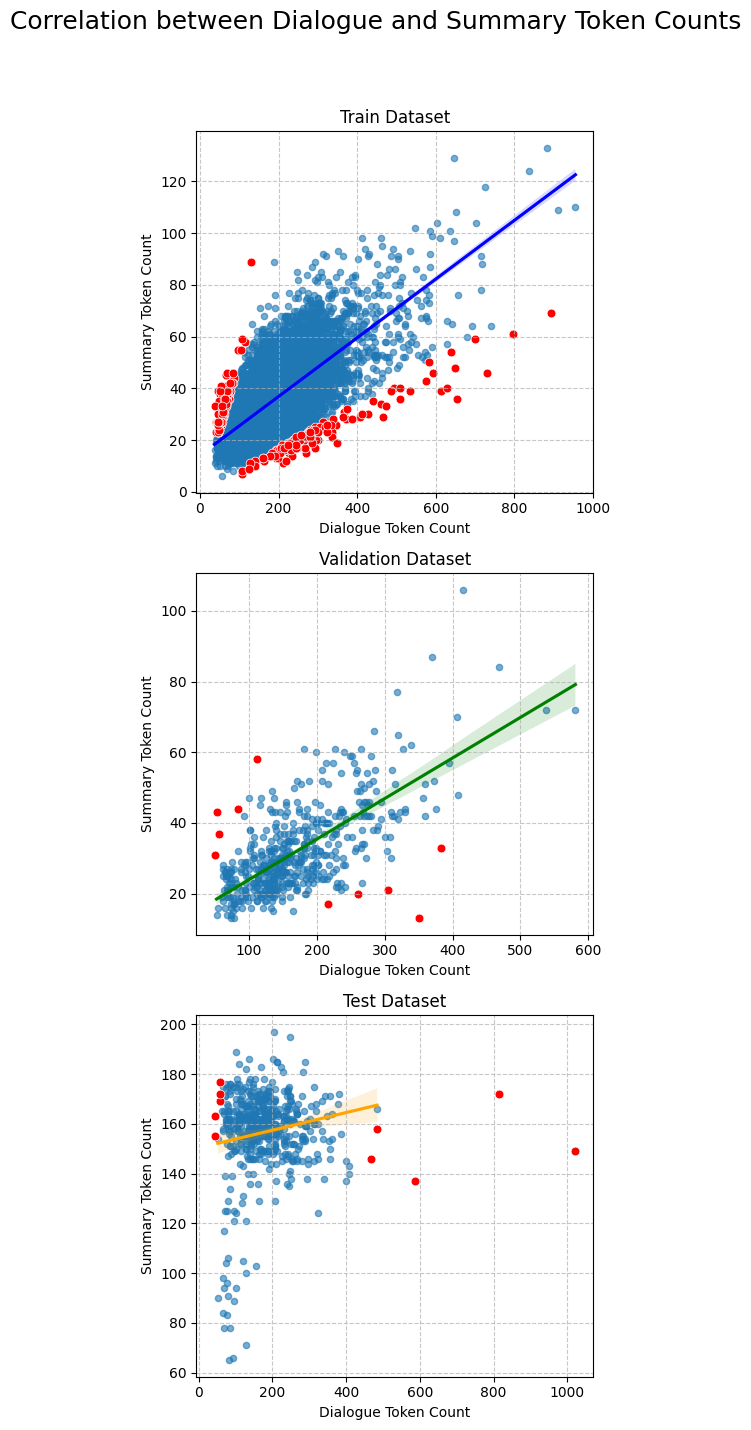

In [28]:
# Create subplots for visualization
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 15))
fig.suptitle('Correlation between Dialogue and Summary Token Counts', fontsize=18, y=0.98)

# Analyze and plot for train_df
analyze_and_plot(train_df, 'Train Dataset', axes[0], 'blue')

# Analyze and plot for val_df
analyze_and_plot(val_df, 'Validation Dataset', axes[1], 'green')

# Analyze and plot for test_df
analyze_and_plot(test_df, 'Test Dataset', axes[2], 'orange')

# Analyze and plot for train_solar
# analyze_and_plot(train_solar_en2ko, 'Train-Solar Dataset', axes[3], 'gray')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

## 모듈

- 46점짜리 submission의 경우 dialogue-summary 길이 상관계수가 0.018 정도에 p-value 0.8이었는데, 48점짜리는 토큰 길이 분포는 큰 차이가 없지만 dial-sum 길이 상관계수가 0.05 정도에 p-value도 0.2수준으로 크게 낮아짐.
   > 즉, dial-sum 상관계수가 높을수록 좋은 점수를 받을 가능성 증가함.